In [1]:
#import sys
#sys.path.append('../../qclib/machine_learning/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate, RealAmplitudes, TwoLocal, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B,SPSA
from qiskit.circuit.library.standard_gates import HGate

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

seed = 42
algorithm_globals.random_seed = 42


from auxData import Load_Data, Load_DataFull, plot_sampled_data_sepal, plot_predicted
from auxQuantum import FeatureMap, Neuron, TTN, FeatureMapFull, WeightlessNN
from feature_vector import FeatureVector
from qclib.state_preparation import BaaLowRankInitialize


In [2]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [3]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# DATASET

In [36]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X, Y = datasets.load_iris(return_X_y=True)
X = np.array(X[:100])
Y = np.array(Y[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((-1, 1)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1

num_inputs = len(X[0])
n_qubits = int(np.log2(num_inputs))

In [5]:
n_qubits

2

# Circuito

In [7]:
def WeightlessNN3qubits():
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)
    qc.append(Neuron("p1", "p2", "p3", "p4"), [0,1,2])
    return qc


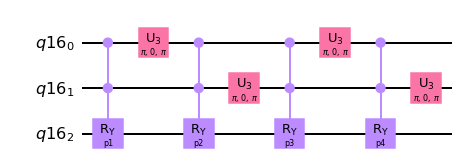

In [16]:
# construct feature map
#feature_map = ZZFeatureMap(num_inputs)
max_F_loss = 0
feature_map = FeatureVector(n_qubits, num_inputs, BaaLowRankInitialize, opt_params=None)

# construct ansatz
#ansatz = RealAmplitudes(feature_map.num_qubits, reps=2)
#ansatz = TwoLocal(feature_map.num_qubits, ['ry','rz'], 'cx', 'full', reps=2)


ansatz = WeightlessNN3qubits()

#feature_map.draw('mpl')

qr = QuantumRegister(3)
qc = QuantumCircuit(qr)
qc.append(feature_map, [0,1])
qc.append(ansatz, [0,1,2])
ansatz.decompose().decompose().draw('mpl')

## Quantum Instance and QNN

In [17]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

hamiltonian = Z ^ I ^ I
qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  
                quantum_instance=quantum_instance)

Cannot compute gradient operator! Continuing without gradients!


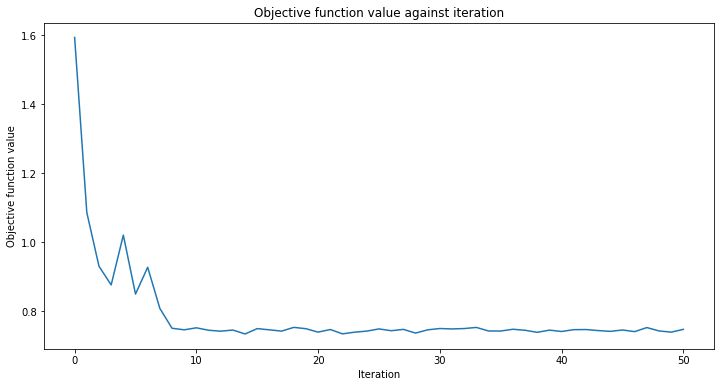

0.73

In [33]:
opflow_classifier = NeuralNetworkClassifier(qnn,  optimizer=COBYLA(maxiter=100),  callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X, y)



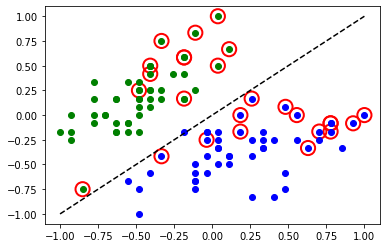

In [34]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [-1, 1], "--", color="black")
plt.show()

## Testando regiões de decisão

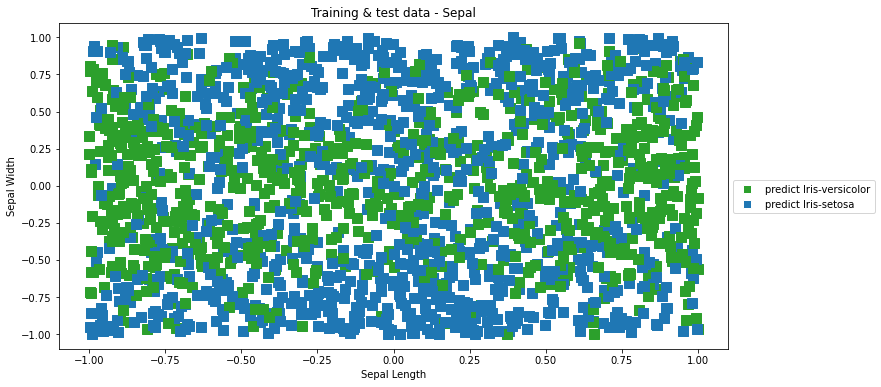

In [35]:
test2_col1 = np.random.uniform(low=-1.0, high=1.0, size=(2000,))
test2_col2 = np.random.uniform(low=-1.0, high=1.0, size=(2000,))
test2_col3 = np.random.uniform(low=-1.0, high=1.0, size=(2000,))
test2_col4 = np.random.uniform(low=-1.0, high=1.0, size=(2000,))
test2= np.vstack((test2_col4,test2_col3, test2_col2, test2_col1)).T

def plot_area(a,b, test_features):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    
    for feature, pred in zip(test_features, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [

        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[b-1], ms=8),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[a-1], ms=8),

    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')

predicted = opflow_classifier.predict(test2)
plot_area(1,2, test2)

KeyboardInterrupt: 

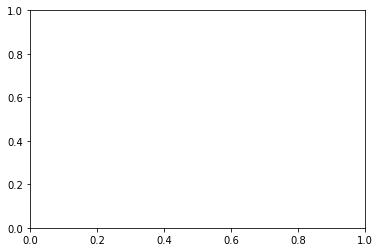

In [14]:
from mlxtend.plotting import plot_decision_regions
# Plotting decision regions
fig, ax = plt.subplots()

std = 5
var = 5
plot_decision_regions(X, y, filler_feature_values={2: std, 3:std},
                      filler_feature_ranges={2: var, 3:var}, clf=opflow_classifier, legend=2, ax=ax)
# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')
plt.show()